# 10 - Generate Zone Busyness Percentiles

### Description
This notebook computes percentile thresholds (from the 10th to 90th percentiles)  
based on historical **zone-level aggregated ridership** per `hour` and `day_of_week`.  
The output is used to support a **6-level busyness classification** that compares  
current or predicted activity to typical historical patterns.

### Busyness Levels

| Busyness Level     | Percentile Range   | Description                            |
|--------------------|--------------------|----------------------------------------|
| Very Quiet         | `< p10`            | Exceptionally low activity             |
| Quiet              | `p10–p25`          | Below-normal ridership                 |
| Moderate           | `p25–p50`          | Typical low-to-average ridership       |
| Busy               | `p50–p75`          | Typical high-to-very high ridership    |
| Very Busy          | `p75–p90`          | Elevated but not extreme activity      |
| Extremely Busy     | `> p90`            | Outlier-level crowding or surges       |

Each classification is zone-specific and contextual. That means "Busy" in one zone  
might represent far fewer riders than "Busy" in a larger zone — but both are meaningful  
within their own local context.

### Step 1: Load and Aggregate Zone-Hour-Day Totals

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
def create_zone_subway_busyness_percentiles(parquet_file_path, mapping_file_path, output_file_path):
    """
    Compute p10, p25, p50, p75, and p90 percentiles for each (zone, hour, day_of_week)
    group based on daily aggregated ridership values.
    """
    print("Loading subway data...")
    subway_data = pd.read_parquet(parquet_file_path)
    mapping = pd.read_csv(mapping_file_path)

    print("Merging with zone mapping...")
    merged = subway_data.merge(mapping, on="station_complex_id", how="inner")

    print("Preprocessing timestamps...")
    merged["timestamp"] = pd.to_datetime(merged["transit_timestamp"])
    merged["date"] = merged["timestamp"].dt.date
    merged["hour"] = merged["timestamp"].dt.hour
    merged["day_of_week"] = merged["timestamp"].dt.dayofweek

    print("Aggregating to daily zone-hour totals...")
    daily_totals = (
        merged.groupby(["PULocationID", "hour", "day_of_week", "date"])["ridership"]
        .sum()
        .reset_index()
    )

    print("Calculating percentiles...")
    percentiles = (
        daily_totals.groupby(["PULocationID", "hour", "day_of_week"])["ridership"]
        .agg([
            ("p10", lambda x: np.percentile(x, 10)),
            ("p25", lambda x: np.percentile(x, 25)),
            ("p50", lambda x: np.percentile(x, 50)),
            ("p75", lambda x: np.percentile(x, 75)),
            ("p90", lambda x: np.percentile(x, 90)),
        ])
        .reset_index()
        .sort_values(["PULocationID", "hour", "day_of_week"])
    )

    percentiles.to_csv(output_file_path, index=False)
    print(f"Saved: {output_file_path} ({len(percentiles)} rows)")
    return percentiles


### Step 2: Classify New Observations by Busyness Level

In [3]:
def classify_six_level_busyness(current_ridership, p10, p25, p50, p75, p90):
    """Assign a 6-level label based on ridership and historical percentiles."""
    if pd.isna(current_ridership) or pd.isna(p10):
        return "Unknown"
    if current_ridership < p10:
        return "Very Quiet"
    elif current_ridership < p25:
        return "Quiet"
    elif current_ridership < p50:
        return "Moderate"
    elif current_ridership < p75:
        return "Busy"
    elif current_ridership < p90:
        return "Very Busy"
    else:
        return "Extremely Busy"

In [4]:
def apply_busyness_level(current_df, percentile_df):
    """
    Attach a 'busyness_level' column to the current_df based on historical percentiles.
    """
    required = ["PULocationID", "hour", "day_of_week", "ridership"]
    for col in required:
        if col not in current_df.columns:
            raise ValueError(f"Missing required column: {col}")

    merged = current_df.merge(
        percentile_df,
        on=["PULocationID", "hour", "day_of_week"],
        how="left"
    )

    merged["busyness_level"] = merged.apply(
        lambda row: classify_six_level_busyness(
            row["ridership"], row["p10"], row["p25"], row["p50"], row["p75"], row["p90"]
        ),
        axis=1
    )

    return merged


### Step 3: Optional Script Entry Point

In [5]:
if __name__ == "__main__":
    # Define paths
    base_dir = Path("C:/Users/neasa/manhattan-subway/data/processed")
    parquet_path = base_dir / "modeling" / "subway_ridership_modeling_features.parquet"
    mapping_path = base_dir / "station_to_zone_mapping.csv"
    output_path = base_dir / "zone_subway_busyness_stats.csv"

    # Generate zone-level percentiles
    percentiles = create_zone_subway_busyness_percentiles(parquet_path, mapping_path, output_path)

    # Test classification on example data
    current = pd.DataFrame({
        "PULocationID": [45, 142],
        "hour": [8, 17],
        "day_of_week": [2, 5],
        "ridership": [520, 230]
    })

    classified = apply_busyness_level(current, percentiles)

    print("\nSample Busyness Classification:")
    print(classified[["PULocationID", "hour", "day_of_week", "ridership", "busyness_level"]])


Loading subway data...
Merging with zone mapping...
Preprocessing timestamps...
Aggregating to daily zone-hour totals...
Calculating percentiles...
Saved: C:\Users\neasa\manhattan-subway\data\processed\zone_subway_busyness_stats.csv (8400 rows)

Sample Busyness Classification:
   PULocationID  hour  day_of_week  ridership busyness_level
0            45     8            2        520     Very Quiet
1           142    17            5        230     Very Quiet


### Step 4: Validate Percentile and Classification Logic

This section checks for the following:

1. Statistical distribution of p10 to p90 values
2. Logical ordering of percentiles (p10 < p25 < p50 < p75 < p90)
3. Zone coverage and completeness of zone-hour-day combinations
4. Visual inspection of percentile profiles for selected zones
5. Alignment between percentile thresholds and assigned busyness classifications

Percentile Summary Statistics:
     min       max         mean
p10  1.0  28388.60  1272.947036
p25  1.0  29788.75  1424.063750
p50  2.0  31204.00  1563.162262
p75  4.0  32094.75  1690.518185
p90  6.0  33082.00  1807.270893


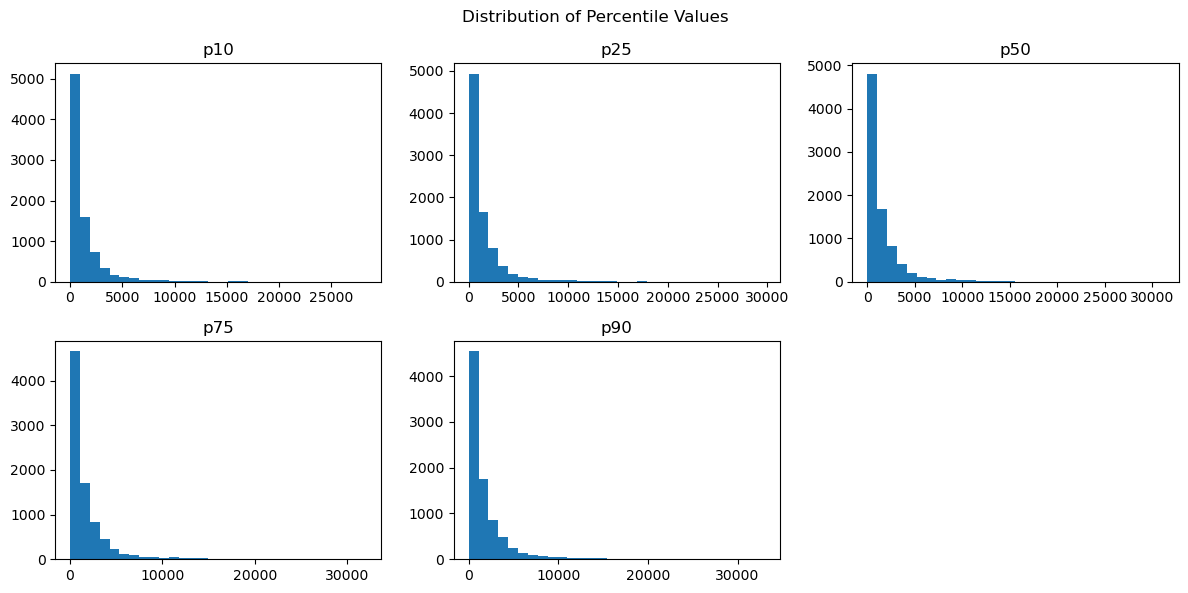

In [6]:
# Summary statistics for percentiles
print("Percentile Summary Statistics:")
print(percentiles[["p10", "p25", "p50", "p75", "p90"]].describe().T[["min", "max", "mean"]])

# Plot histograms of percentile distributions
percentiles[["p10", "p25", "p50", "p75", "p90"]].hist(
    bins=30, figsize=(12, 6), layout=(2, 3), grid=False
)
plt.suptitle("Distribution of Percentile Values")
plt.tight_layout()
plt.show()


In [7]:
# Confirm proper ascending percentile structure
violations = percentiles[
    (percentiles["p10"] > percentiles["p25"]) |
    (percentiles["p25"] > percentiles["p50"]) |
    (percentiles["p50"] > percentiles["p75"]) |
    (percentiles["p75"] > percentiles["p90"])
]

if not violations.empty:
    print(f"{len(violations)} violations found in percentile ordering:")
    display(violations.head())
else:
    print("All percentiles follow expected ascending order.")


All percentiles follow expected ascending order.


In [8]:
zone_count = percentiles["PULocationID"].nunique()
row_count = len(percentiles)
print(f"Zones covered: {zone_count}")
print(f"Total rows: {row_count}")
print("Expected rows per zone: ~168 (24 hrs × 7 days)\n")

zone_row_counts = percentiles["PULocationID"].value_counts().value_counts()
print("Distribution of entry counts per zone:")
print(zone_row_counts.sort_index())


Zones covered: 50
Total rows: 8400
Expected rows per zone: ~168 (24 hrs × 7 days)

Distribution of entry counts per zone:
count
168    50
Name: count, dtype: int64


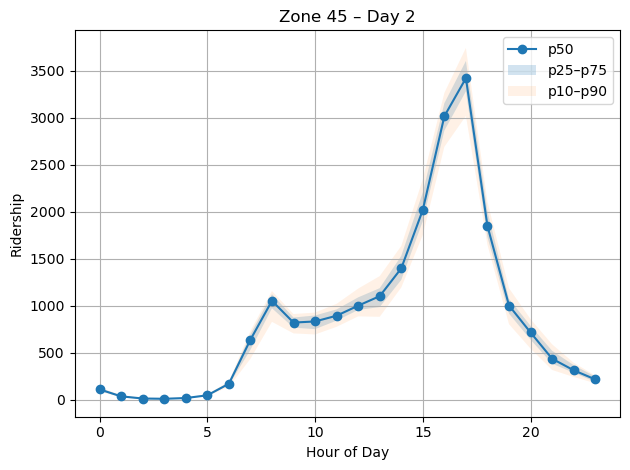

In [9]:
def plot_zone_busyness_profile(PULocationID, day_of_week):
    subset = percentiles[
        (percentiles["PULocationID"] == PULocationID) & 
        (percentiles["day_of_week"] == day_of_week)
    ].sort_values("hour")

    if subset.empty:
        print("No data available for selected zone/day.")
        return

    plt.plot(subset["hour"], subset["p50"], label="p50", marker="o")
    plt.fill_between(subset["hour"], subset["p25"], subset["p75"], alpha=0.2, label="p25–p75")
    plt.fill_between(subset["hour"], subset["p10"], subset["p90"], alpha=0.1, label="p10–p90")
    plt.title(f"Zone {PULocationID} – Day {day_of_week}")
    plt.xlabel("Hour of Day")
    plt.ylabel("Ridership")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example plot
plot_zone_busyness_profile(PULocationID=45, day_of_week=2)


In [10]:
print("Sample classification with percentiles:")
print(classified[["PULocationID", "hour", "day_of_week", "ridership", 
                  "p10", "p25", "p50", "p75", "p90", "busyness_level"]].head(10))

Sample classification with percentiles:
   PULocationID  hour  day_of_week  ridership     p10      p25     p50  \
0            45     8            2        520   830.8   975.25  1055.0   
1           142    17            5        230  3334.4  3737.50  4202.5   

       p75     p90 busyness_level  
0  1125.00  1159.0     Very Quiet  
1  4885.25  5293.2     Very Quiet  
